In [74]:
import numpy as np
import pandas

from consts import *
from data_genertion.consts import *
from util import get_antisense, get_gc_content

In [75]:
all_data = pandas.read_csv(DATA_PATH / 'data_from_article_fixed.csv')

In [76]:
all_data['gc_content'] = [get_gc_content(seq) for seq in all_data[SEQUENCE]]

In [77]:
from scipy.stats import pearsonr, spearmanr

def print_correlations(df, name1, name2, p_value_threshold=None):
    if p_value_threshold is None:
        p_value_threshold = 1
    corr, p_value = pearsonr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Pearson: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")
    corr, p_value = spearmanr(df[name1], df[name2])
    if p_value < p_value_threshold:
        print(f"Feature: {name1:<35}, Spearman: {corr:<5.2f}, p-value: {p_value:<10.2} Target: {name2:<35}")


In [78]:
all_data_no_nan = all_data.dropna(subset=[INHIBITION]).copy()

In [79]:
all_data_no_nan.loc[:, 'log_inhibition'] = -np.log(-all_data_no_nan[INHIBITION] + 101)
print("Max: ", np.max(all_data_no_nan['log_inhibition']))
print("Min: ", np.min(all_data_no_nan['log_inhibition']))
print("Max: ", np.max(all_data_no_nan[INHIBITION]))
print("Min: ", np.min(all_data_no_nan[INHIBITION]))

Max:  -0.0
Min:  -6.787844982309579
Max:  100.0
Min:  -786.0


In [80]:
import ViennaRNA as RNA
all_data_no_nan.loc[:, 'internal_fold'] = [RNA.fold(antisense)[1] for antisense in all_data_no_nan[SEQUENCE]]

print_correlations(all_data_no_nan, 'internal_fold', INHIBITION)
print_correlations(all_data_no_nan, 'internal_fold', 'log_inhibition')

Feature: internal_fold                      , Pearson: 0.01 , p-value: 0.038      Target: Inhibition(%)                      
Feature: internal_fold                      , Spearman: 0.00 , p-value: 0.7        Target: Inhibition(%)                      
Feature: internal_fold                      , Pearson: 0.01 , p-value: 0.012      Target: log_inhibition                     
Feature: internal_fold                      , Spearman: 0.00 , p-value: 0.7        Target: log_inhibition                     


In [81]:
CANONICAL_GENE = 'Canonical Gene Name'
CELL_LINE_ORGANISM = 'Cell line organism'

all_data_no_nan_human = all_data_no_nan[all_data_no_nan[CELL_LINE_ORGANISM] == 'human']
genes = all_data_no_nan[CANONICAL_GENE].copy()
genes_u = list(set(genes))
genes_u.remove('HBV')
genes_u.remove('negative_control')

In [82]:
from read_human_genome import get_locus_to_data_dict
import pickle
from consts import CACHE_DIR


cache_path = CACHE_DIR / 'gene_to_data_simple_cache.pickle'
if not cache_path.exists():
    gene_to_data = get_locus_to_data_dict(include_introns=True, gene_subset=genes_u)
    with open(cache_path, 'wb') as f:
        pickle.dump(gene_to_data, f)
else:
    with open(cache_path, 'rb') as f:
        gene_to_data = pickle.load(f)

In [83]:
for gene_name in genes_u:
    if gene_name not in gene_to_data:
        print(f"gene : {gene_name} not found")

In [84]:
from asodesigner.util import get_antisense

all_data_human_gene = all_data_no_nan_human[all_data_no_nan_human[CANONICAL_GENE].isin(genes_u)].copy()
PREMRNA_FOUND = 'pre_mrna_found'
SENSE_START = 'sense_start'
SENSE_LENGTH = 'sense_length'
SENSE_TYPE = 'sense_type'

found = 0
not_found = 0
all_data_human_gene[SENSE_START] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)
all_data_human_gene[SENSE_LENGTH] = np.zeros_like(all_data_human_gene[CANONICAL_GENE], dtype=int)
all_data_human_gene[SENSE_TYPE] = "NA"
for index, row in all_data_human_gene.iterrows():
     gene_name = row[CANONICAL_GENE]
     locus_info = gene_to_data[gene_name]
     pre_mrna = locus_info.full_mrna
     antisense = row[SEQUENCE]
     sense = get_antisense(antisense)
     idx = pre_mrna.find(sense)
     all_data_human_gene.loc[index, SENSE_START] = idx
     all_data_human_gene.loc[index, SENSE_LENGTH] = len(antisense)
     if idx != -1:
         genome_corrected_index = idx + locus_info.exon_indices[0][0]
         found = False

         if genome_corrected_index < locus_info.exon_indices[0][0]:
            all_data_human_gene.loc[index, SENSE_TYPE] = '5UTR'
            continue
         if genome_corrected_index >= locus_info.exon_indices[-1][-1]:
            all_data_human_gene.loc[index, SENSE_TYPE] = '3UTR'
            continue
         for exon_indices in locus_info.exon_indices:
            # print(exon[0], exon[1])
            if exon_indices[0] <=  genome_corrected_index <= exon_indices[1]:
                all_data_human_gene.loc[index, SENSE_TYPE] = 'exon'
                found = True
                break
     if not found:
         all_data_human_gene.loc[index, SENSE_TYPE] = 'intron'


In [85]:
all_data_human_gene_premrna = all_data_human_gene[all_data_human_gene[SENSE_START] != -1]
len(all_data_human_gene_premrna)


29987

In [86]:
from fold import get_trigger_mfe_scores_by_risearch, get_mfe_scores, dump_target_file
import random

# minimal_scores = [200,400,600,800,1000,1200]
minimal_scores = [800]
on_target_feature_titles = ['on_target_energy_fits', 'on_target_energy_sum', 'on_target_energy_max']

all_data_human_gene_premrna = all_data_human_gene_premrna.copy() # so Jupyter doesn't shout at me

# genes_u.remove('HIF1A') # the same sequence for all ASOs, only differing chemical modifications
for score in minimal_scores:
    for feature_title in on_target_feature_titles:
        all_data_human_gene_premrna.loc[:, feature_title + str(score)] = np.zeros_like(all_data_human_gene_premrna[SEQUENCE], dtype=np.float64)

    for gene in genes_u:
        target = gene_to_data[gene].full_mrna
        name_to_sequence = {'target_seq' : target}
        results = []
        parsing_type = '2'

        hash = random.getrandbits(64)
        target_cache_filename = f'target-cache-{hash}.fa'
        target_cache_path = dump_target_file(target_cache_filename, name_to_sequence)

        gene_rows = all_data_human_gene_premrna[all_data_human_gene_premrna[CANONICAL_GENE] == gene]

        for index, row in gene_rows.iterrows():
            antisense = row[SEQUENCE]
            sense = get_antisense(antisense)
            l = row[SENSE_LENGTH]
            # TODO: din, add DNA-RNA, PSDNA-RNA
            tmp_results = get_trigger_mfe_scores_by_risearch(sense, name_to_sequence, minimum_score=score, neighborhood=l,
                                                     parsing_type=parsing_type, target_file_cache=target_cache_path)
            scores = get_mfe_scores(tmp_results, parsing_type)
            if len(scores) == 0:
                all_data_human_gene_premrna.loc[index, 'on_target_energy_fits' + str(score)] = 0.
                all_data_human_gene_premrna.loc[index, 'on_target_energy_sum' + str(score)] = 0.
                all_data_human_gene_premrna.loc[index, 'on_target_energy_max' + str(score)] = 0.
            else:
                target_scores = scores[0]
                min_score = 0 if len(target_scores) == 0 else min(target_scores)
                all_data_human_gene_premrna.loc[index, 'on_target_energy_fits' + str(score)] = len(target_scores)
                all_data_human_gene_premrna.loc[index, 'on_target_energy_sum' + str(score)] = sum(target_scores)
                all_data_human_gene_premrna.loc[index, 'on_target_energy_max' + str(score)] = min_score



In [87]:
on_target_energy_features = ['on_target_energy_fits' + str(score) for score in minimal_scores] + ['on_target_energy_sum' + str(score) for score in minimal_scores] + ['on_target_energy_max' + str(score) for score in minimal_scores]
on_target_energy_features

['on_target_energy_fits800',
 'on_target_energy_sum800',
 'on_target_energy_max800']

In [88]:
for score in minimal_scores:
    for on_target_name in on_target_feature_titles:
        all_data_human_gene_premrna.loc[:, on_target_name + "_normalized" + str(score)] = all_data_human_gene_premrna['on_target_energy_fits' + str(score)] / all_data_human_gene_premrna[SENSE_LENGTH]
        on_target_energy_features.append(on_target_name + "_normalized" + str(score))

        ISIS Target_gene Cell_line  Density(cells/well)     Transfection  \
996   709836        SNCA   SH-SY5Y              20000.0  electroporation   
1424  740331        SNCA   SH-SY5Y              20000.0  electroporation   
1220  709839        SNCA   SH-SY5Y              20000.0  electroporation   
1425  740332        SNCA   SH-SY5Y              20000.0  electroporation   
1426  740333        SNCA   SH-SY5Y              20000.0  electroporation   

      ASO_volume(nM)  Treatment_Period(hours) Primer_probe_set  \
996           7000.0                       24          RTS2621   
1424          7000.0                       24          RTS2621   
1220          7000.0                       24          RTS2621   
1425          7000.0                       24          RTS2621   
1426          7000.0                       24          RTS2621   

               Sequence                     Modification  ... internal_fold  \
996   GGCGACGCGAGGCTGGG  MOE/cEt/5-methylcytosines/deoxy  ...      

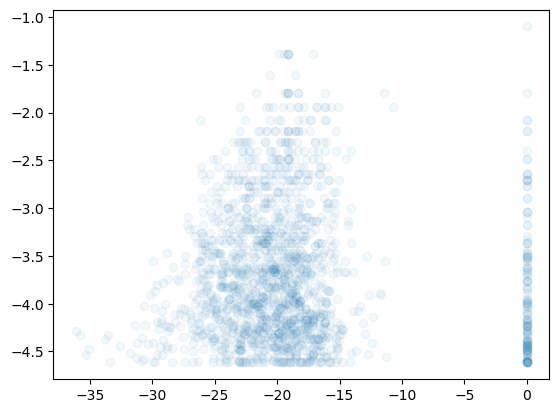

In [89]:
import matplotlib.pyplot as plt

test = all_data_human_gene_premrna[all_data_human_gene_premrna[CANONICAL_GENE] == 'SNCA']
test = test.sort_values(by=['on_target_energy_max800'], ascending=[False])
print(test.tail(5))
plt.scatter(test['on_target_energy_max800'], test['log_inhibition'], alpha=0.05)
plt.show()

In [90]:
from fold import calculate_energies, get_weighted_energy

all_data_human_gene_premrna_no_nan = all_data_human_gene_premrna.copy()

# Comment out the long cases for quick running
# fold_variants = [(40, 15), (60, 15), (80, 15), (100, 15), (60, 25), (80, 25), (100, 25), (80, 40), (100, 40)]
fold_variants = [(40, 15)]
for (window_size, step_size) in fold_variants:
    for gene in genes_u:
        on_target_fold = 'on_target_fold_openness' + str(window_size) + '_' + str(step_size)
        on_target_fold_normalized = 'on_target_fold_openness_normalized' + str(window_size) + '_' + str(step_size)
        # on_target_fold = 'on_target_fold_openness'
        # on_target_fold_normalized = 'on_target_fold_openness_normalized'


        all_data_human_gene_premrna_no_nan[on_target_fold] = np.zeros_like(all_data_human_gene_premrna_no_nan[SEQUENCE], dtype=np.float64)
        all_data_human_gene_premrna_no_nan[on_target_fold_normalized] = np.zeros_like(all_data_human_gene_premrna_no_nan[SEQUENCE], dtype=np.float64)


        target = gene_to_data[gene].full_mrna
        gene_rows = all_data_human_gene_premrna_no_nan[all_data_human_gene_premrna_no_nan[CANONICAL_GENE] == gene]
        energies = calculate_energies(str(target), step_size, window_size)

        for index, row in gene_rows.iterrows():
            antisense = row[SEQUENCE]
            sense = get_antisense(antisense)
            l = row[SENSE_LENGTH]
            sense_start = row[SENSE_START]
            mean_fold = get_weighted_energy(sense_start, l, step_size, energies, window_size)

            all_data_human_gene_premrna_no_nan.loc[index, on_target_fold] = mean_fold
            all_data_human_gene_premrna_no_nan.loc[index, on_target_fold_normalized] = mean_fold / l


In [91]:
fold_feature_names = ['on_target_fold_openness', 'on_target_fold_openness_normalized']
fold_features = []
for (window_size, step_size) in fold_variants:
    for feature_name in fold_feature_names:
        fold_features.append(feature_name + str(window_size) + "_" + str(step_size))

In [92]:
print(all_data_human_gene_premrna_no_nan.columns)

Index(['ISIS', 'Target_gene', 'Cell_line', 'Density(cells/well)',
       'Transfection', 'ASO_volume(nM)', 'Treatment_Period(hours)',
       'Primer_probe_set', 'Sequence', 'Modification', 'Location',
       'Chemical_Pattern', 'Linkage', 'Linkage_Location', 'Smiles',
       'Inhibition(%)', 'seq_length', 'Canonical Gene Name',
       'Cell line organism', 'gc_content', 'log_inhibition', 'internal_fold',
       'sense_start', 'sense_length', 'sense_type', 'on_target_energy_fits800',
       'on_target_energy_sum800', 'on_target_energy_max800',
       'on_target_energy_fits_normalized800',
       'on_target_energy_sum_normalized800',
       'on_target_energy_max_normalized800', 'on_target_fold_openness40_15',
       'on_target_fold_openness_normalized40_15'],
      dtype='object')


Feature: on_target_fold_openness40_15       , Pearson: -0.19, p-value: 1.8e-236   Target: Inhibition(%)                      
Feature: on_target_fold_openness40_15       , Spearman: -0.24, p-value: 0.0        Target: Inhibition(%)                      
Feature: on_target_fold_openness40_15       , Pearson: -0.23, p-value: 0.0        Target: log_inhibition                     
Feature: on_target_fold_openness40_15       , Spearman: -0.24, p-value: 0.0        Target: log_inhibition                     
Feature: on_target_fold_openness_normalized40_15, Pearson: -0.19, p-value: 1.8e-236   Target: Inhibition(%)                      
Feature: on_target_fold_openness_normalized40_15, Spearman: -0.24, p-value: 0.0        Target: Inhibition(%)                      
Feature: on_target_fold_openness_normalized40_15, Pearson: -0.23, p-value: 0.0        Target: log_inhibition                     
Feature: on_target_fold_openness_normalized40_15, Spearman: -0.24, p-value: 0.0        Target: log_inhi

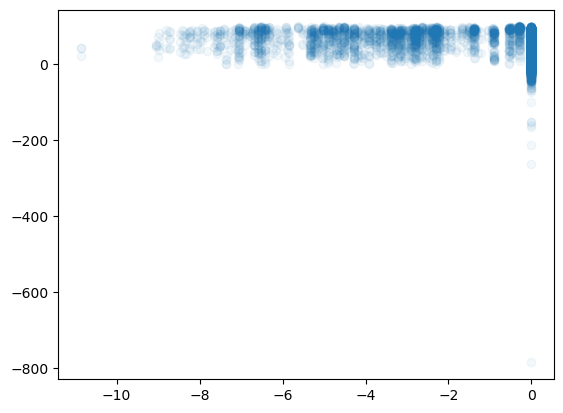

In [93]:
test = all_data_human_gene_premrna_no_nan
# test = all_data_human_gene_premrna_no_nan[all_data_human_gene_premrna_no_nan[INHIBITION] > 0]


for feature_name in fold_features:
    print_correlations(test , feature_name, INHIBITION, p_value_threshold=0.05)
    print_correlations(test , feature_name, 'log_inhibition', p_value_threshold=0.05)

feature = fold_features[0]
plt.scatter(test[feature], test[INHIBITION], alpha=0.05)
plt.show()


In [94]:
all_data_human_gene_premrna_no_nan.loc[:, 'energy_and_fold'] = all_data_human_gene_premrna_no_nan['on_target_energy_max800'] * all_data_human_gene_premrna_no_nan['on_target_fold_openness_normalized40_15']

print_correlations(all_data_human_gene_premrna_no_nan, 'energy_and_fold', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'energy_and_fold', 'log_inhibition')

Feature: energy_and_fold                    , Pearson: 0.16 , p-value: 5.5e-171   Target: Inhibition(%)                      
Feature: energy_and_fold                    , Spearman: 0.21 , p-value: 7.8e-288   Target: Inhibition(%)                      
Feature: energy_and_fold                    , Pearson: 0.18 , p-value: 3.9e-227   Target: log_inhibition                     
Feature: energy_and_fold                    , Spearman: 0.21 , p-value: 7.8e-288   Target: log_inhibition                     


In [95]:
import primer3

all_data_human_gene_premrna_no_nan.loc[:, 'self_energy'] = [float(primer3.calc_homodimer(antisense).dg) for antisense in all_data_human_gene_premrna_no_nan[SEQUENCE]]
all_data_human_gene_premrna_no_nan.loc[:, 'self_energy'] = all_data_human_gene_premrna_no_nan.loc[:, 'self_energy'].astype(float)

print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy', 'log_inhibition')

Feature: self_energy                        , Pearson: 0.02 , p-value: 0.0013     Target: Inhibition(%)                      
Feature: self_energy                        , Spearman: 0.01 , p-value: 0.095      Target: Inhibition(%)                      
Feature: self_energy                        , Pearson: 0.01 , p-value: 0.024      Target: log_inhibition                     
Feature: self_energy                        , Spearman: 0.01 , p-value: 0.095      Target: log_inhibition                     


In [96]:
all_data_human_gene_premrna_no_nan.loc[:, 'internal_fold'] = [RNA.fold(antisense)[1] for antisense in all_data_human_gene_premrna_no_nan[SEQUENCE]]

print_correlations(all_data_human_gene_premrna_no_nan, 'internal_fold', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'internal_fold', 'log_inhibition')

Feature: internal_fold                      , Pearson: 0.00 , p-value: 0.66       Target: Inhibition(%)                      
Feature: internal_fold                      , Spearman: 0.00 , p-value: 0.6        Target: Inhibition(%)                      
Feature: internal_fold                      , Pearson: -0.02, p-value: 0.0016     Target: log_inhibition                     
Feature: internal_fold                      , Spearman: 0.00 , p-value: 0.6        Target: log_inhibition                     


In [97]:
all_data_human_gene_premrna_no_nan.loc[:, 'gc_content_5_prime_5'] = [get_gc_content(sequence[:5]) for sequence in all_data_human_gene_premrna_no_nan[SEQUENCE]]
all_data_human_gene_premrna_no_nan.loc[:, 'gc_content_3_prime_5'] = [get_gc_content(sequence[-5:]) for sequence in all_data_human_gene_premrna_no_nan[SEQUENCE]]
all_data_human_gene_premrna_no_nan.loc[:, 'first_nucleotide'] = [sequence[0] for sequence in all_data_human_gene_premrna_no_nan[SEQUENCE]]
all_data_human_gene_premrna_no_nan.loc[:, 'second_nucleotide'] = [sequence[2] for sequence in all_data_human_gene_premrna_no_nan[SEQUENCE]]

print_correlations(all_data_human_gene_premrna_no_nan, 'gc_content_5_prime_5', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'gc_content_5_prime_5', 'log_inhibition')
print_correlations(all_data_human_gene_premrna_no_nan, 'gc_content_3_prime_5', 'log_inhibition')
print_correlations(all_data_human_gene_premrna_no_nan, 'gc_content_3_prime_5', 'log_inhibition')

Feature: gc_content_5_prime_5               , Pearson: -0.03, p-value: 1.4e-06    Target: Inhibition(%)                      
Feature: gc_content_5_prime_5               , Spearman: -0.02, p-value: 0.00013    Target: Inhibition(%)                      
Feature: gc_content_5_prime_5               , Pearson: -0.02, p-value: 0.00013    Target: log_inhibition                     
Feature: gc_content_5_prime_5               , Spearman: -0.02, p-value: 0.00013    Target: log_inhibition                     
Feature: gc_content_3_prime_5               , Pearson: 0.05 , p-value: 1.2e-17    Target: log_inhibition                     
Feature: gc_content_3_prime_5               , Spearman: 0.04 , p-value: 6.6e-12    Target: log_inhibition                     
Feature: gc_content_3_prime_5               , Pearson: 0.05 , p-value: 1.2e-17    Target: log_inhibition                     
Feature: gc_content_3_prime_5               , Spearman: 0.04 , p-value: 6.6e-12    Target: log_inhibition          

In [98]:
import primer3

all_data_human_gene_premrna_no_nan.loc[:, 'self_energy'] = [primer3.calc_homodimer(antisense).dg for antisense in all_data_human_gene_premrna_no_nan[SEQUENCE]]
all_data_human_gene_premrna_no_nan.loc[:, 'self_energy_log'] = -np.log(2500-all_data_human_gene_premrna_no_nan.loc[:, 'self_energy'])

print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy', 'log_inhibition')
print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy_log', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'self_energy_log', 'log_inhibition')

Feature: self_energy                        , Pearson: 0.02 , p-value: 0.0013     Target: Inhibition(%)                      
Feature: self_energy                        , Spearman: 0.01 , p-value: 0.095      Target: Inhibition(%)                      
Feature: self_energy                        , Pearson: 0.01 , p-value: 0.024      Target: log_inhibition                     
Feature: self_energy                        , Spearman: 0.01 , p-value: 0.095      Target: log_inhibition                     
Feature: self_energy_log                    , Pearson: 0.01 , p-value: 0.32       Target: Inhibition(%)                      
Feature: self_energy_log                    , Spearman: 0.01 , p-value: 0.095      Target: Inhibition(%)                      
Feature: self_energy_log                    , Pearson: 0.00 , p-value: 0.54       Target: log_inhibition                     
Feature: self_energy_log                    , Spearman: 0.01 , p-value: 0.095      Target: log_inhibition          

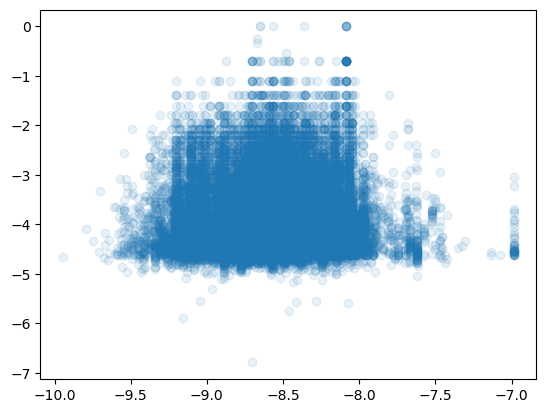

In [99]:
import matplotlib.pyplot as plt
plt.scatter(all_data_human_gene_premrna_no_nan['self_energy_log'], all_data_human_gene_premrna_no_nan['log_inhibition'], alpha=0.1)
plt.show()

Feature: Treatment_Period(hours)            , Pearson: -0.15, p-value: 3.2e-143   Target: Inhibition(%)                      
Feature: Treatment_Period(hours)            , Spearman: -0.27, p-value: 0.0        Target: Inhibition(%)                      
Feature: Treatment_Period(hours)            , Pearson: -0.14, p-value: 6.2e-135   Target: log_inhibition                     
Feature: Treatment_Period(hours)            , Spearman: -0.27, p-value: 0.0        Target: log_inhibition                     


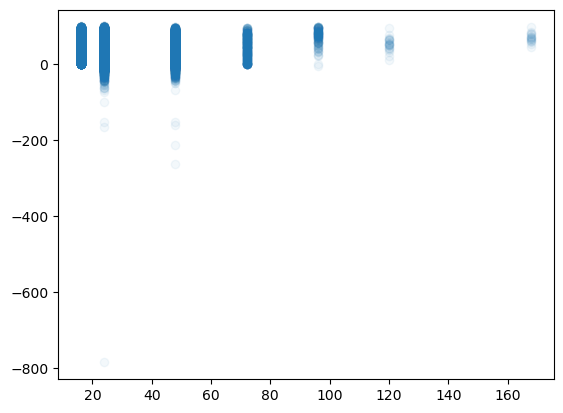

In [100]:
print_correlations(all_data_human_gene_premrna_no_nan, TREATMENT_PERIOD, INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, TREATMENT_PERIOD, 'log_inhibition')
plt.scatter(all_data_human_gene_premrna_no_nan[TREATMENT_PERIOD], all_data_human_gene_premrna_no_nan[INHIBITION], alpha=0.05)
plt.show()

Feature: Density(cells/well)                , Pearson: 0.17 , p-value: 1.5e-168   Target: Inhibition(%)                      
Feature: Density(cells/well)                , Spearman: 0.18 , p-value: 1e-195     Target: Inhibition(%)                      
Feature: Density(cells/well)                , Pearson: 0.10 , p-value: 5e-60      Target: log_inhibition                     
Feature: Density(cells/well)                , Spearman: 0.18 , p-value: 1e-195     Target: log_inhibition                     
Feature: log_density                        , Pearson: 0.17 , p-value: 8.6e-172   Target: Inhibition(%)                      
Feature: log_density                        , Spearman: 0.18 , p-value: 1e-195     Target: Inhibition(%)                      
Feature: log_density                        , Pearson: 0.11 , p-value: 2.4e-69    Target: log_inhibition                     
Feature: log_density                        , Spearman: 0.18 , p-value: 1e-195     Target: log_inhibition          

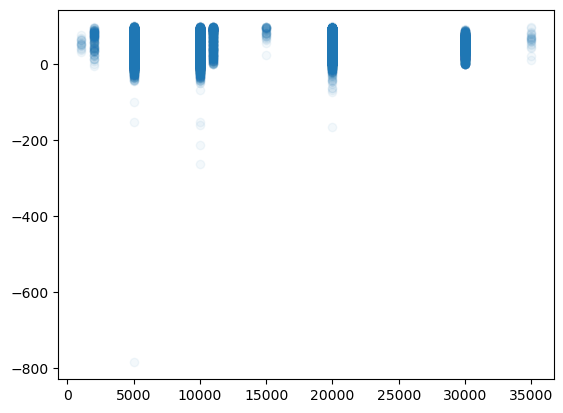

In [101]:
tmp = all_data_human_gene_premrna_no_nan.copy()
tmp = tmp.dropna(subset=[DENSITY]).copy()
tmp.loc[:, 'log_density'] = np.log(tmp[DENSITY])

print_correlations(tmp, DENSITY, INHIBITION)
print_correlations(tmp, DENSITY, 'log_inhibition')
print_correlations(tmp, 'log_density', INHIBITION)
print_correlations(tmp, 'log_density', 'log_inhibition')
plt.scatter(tmp[DENSITY], tmp[INHIBITION], alpha=0.05)
plt.show()

Feature: normalized_start                   , Pearson: 0.10 , p-value: 5.5e-66    Target: Inhibition(%)                      
Feature: normalized_start                   , Spearman: 0.10 , p-value: 1.5e-67    Target: Inhibition(%)                      
Feature: normalized_start                   , Pearson: 0.06 , p-value: 2.7e-22    Target: log_inhibition                     
Feature: normalized_start                   , Spearman: 0.10 , p-value: 1.5e-67    Target: log_inhibition                     


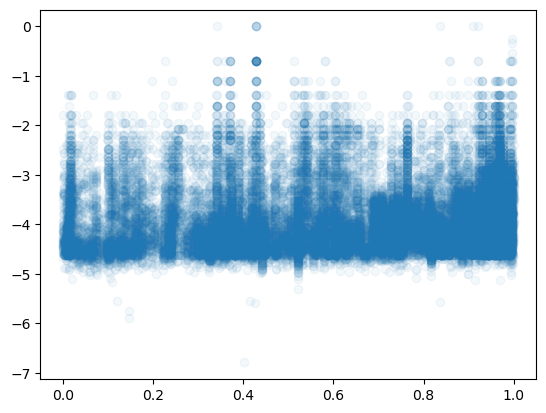

In [102]:
all_data_human_gene_premrna_no_nan.loc[:, 'mrna_length'] = [len(gene_to_data[gene].full_mrna) for gene in all_data_human_gene_premrna_no_nan[CANONICAL_GENE]]
all_data_human_gene_premrna_no_nan.loc[:, 'normalized_start'] = all_data_human_gene_premrna_no_nan[SENSE_START] / all_data_human_gene_premrna_no_nan['mrna_length']

print_correlations(all_data_human_gene_premrna_no_nan, 'normalized_start', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'normalized_start', 'log_inhibition')


plt.scatter(all_data_human_gene_premrna_no_nan['normalized_start'], all_data_human_gene_premrna_no_nan['log_inhibition'], alpha=0.05)
plt.show()

Feature: aso_enc                            , Pearson: 0.02 , p-value: 0.0003     Target: Inhibition(%)                      
Feature: aso_enc                            , Spearman: 0.02 , p-value: 0.00095    Target: Inhibition(%)                      
Feature: aso_enc                            , Pearson: 0.01 , p-value: 0.026      Target: log_inhibition                     
Feature: aso_enc                            , Spearman: 0.02 , p-value: 0.00095    Target: log_inhibition                     


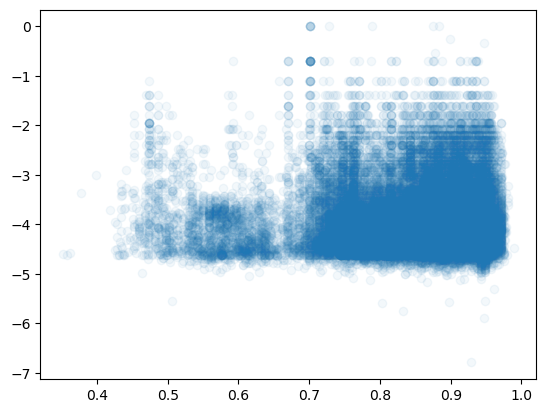

In [103]:
from asodesigner.features.seq_features import compute_ENC
all_data_human_gene_premrna_no_nan.loc[:, 'aso_enc'] = [compute_ENC(aso) for aso in all_data_human_gene_premrna_no_nan[SEQUENCE]]

print_correlations(all_data_human_gene_premrna_no_nan, 'aso_enc', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'aso_enc', 'log_inhibition')


plt.scatter(all_data_human_gene_premrna_no_nan['aso_enc'], all_data_human_gene_premrna_no_nan['log_inhibition'], alpha=0.05)
plt.show()


Feature: aso_entropy                        , Pearson: 0.04 , p-value: 9.7e-13    Target: Inhibition(%)                      
Feature: aso_entropy                        , Spearman: 0.04 , p-value: 4.9e-12    Target: Inhibition(%)                      
Feature: aso_entropy                        , Pearson: 0.03 , p-value: 2e-08      Target: log_inhibition                     
Feature: aso_entropy                        , Spearman: 0.04 , p-value: 4.9e-12    Target: log_inhibition                     


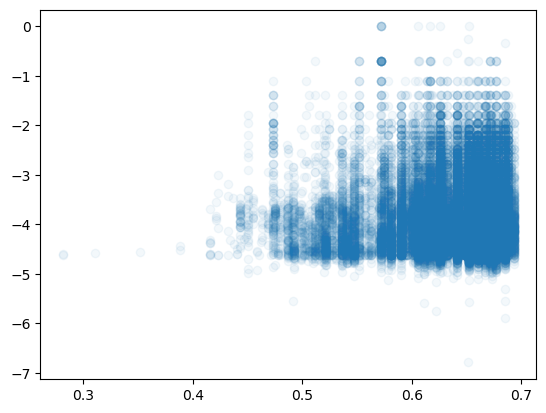

In [104]:
from asodesigner.features.seq_features import seq_entropy
all_data_human_gene_premrna_no_nan.loc[:, 'aso_entropy'] = [seq_entropy(aso) for aso in all_data_human_gene_premrna_no_nan[SEQUENCE]]

print_correlations(all_data_human_gene_premrna_no_nan, 'aso_entropy', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'aso_entropy', 'log_inhibition')


plt.scatter(all_data_human_gene_premrna_no_nan['aso_entropy'], all_data_human_gene_premrna_no_nan['log_inhibition'], alpha=0.05)
plt.show()

Feature: aso_palindromic_fraction           , Pearson: -0.03, p-value: 2e-07      Target: Inhibition(%)                      
Feature: aso_palindromic_fraction           , Spearman: -0.04, p-value: 1.9e-11    Target: Inhibition(%)                      
Feature: aso_palindromic_fraction           , Pearson: -0.02, p-value: 0.0015     Target: log_inhibition                     
Feature: aso_palindromic_fraction           , Spearman: -0.04, p-value: 1.9e-11    Target: log_inhibition                     


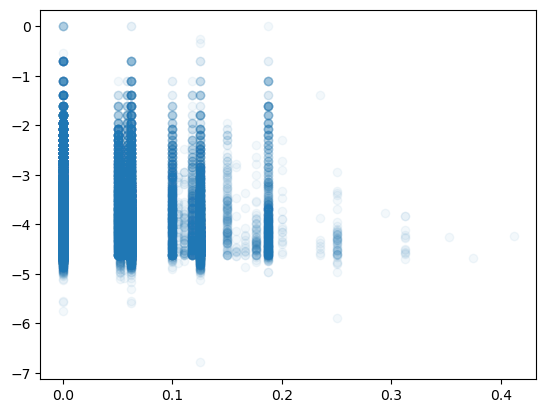

In [105]:
from asodesigner.features.seq_features import palindromic_fraction
all_data_human_gene_premrna_no_nan.loc[:, 'aso_palindromic_fraction'] = [palindromic_fraction(aso, 4) for aso in all_data_human_gene_premrna_no_nan[SEQUENCE]]

print_correlations(all_data_human_gene_premrna_no_nan, 'aso_palindromic_fraction', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'aso_palindromic_fraction', 'log_inhibition')


plt.scatter(all_data_human_gene_premrna_no_nan['aso_palindromic_fraction'], all_data_human_gene_premrna_no_nan['log_inhibition'], alpha=0.05)
plt.show()

Feature: aso_stop_codon_count               , Pearson: -0.02, p-value: 0.00071    Target: Inhibition(%)                      
Feature: aso_stop_codon_count               , Spearman: -0.04, p-value: 1.1e-10    Target: Inhibition(%)                      
Feature: aso_stop_codon_count               , Pearson: -0.03, p-value: 3.2e-08    Target: log_inhibition                     
Feature: aso_stop_codon_count               , Spearman: -0.04, p-value: 1.1e-10    Target: log_inhibition                     


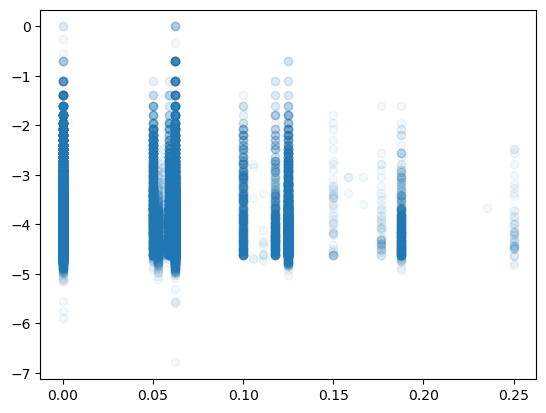

In [106]:
from asodesigner.features.seq_features import stop_codon_count
all_data_human_gene_premrna_no_nan.loc[:, 'aso_stop_codon_count'] = [stop_codon_count(aso) for aso in all_data_human_gene_premrna_no_nan[SEQUENCE]]

print_correlations(all_data_human_gene_premrna_no_nan, 'aso_stop_codon_count', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'aso_stop_codon_count', 'log_inhibition')


plt.scatter(all_data_human_gene_premrna_no_nan['aso_stop_codon_count'], all_data_human_gene_premrna_no_nan['log_inhibition'], alpha=0.05)
plt.show()

Feature: aso_tai_sc                         , Pearson: -0.01, p-value: 0.028      Target: Inhibition(%)                      
Feature: aso_tai_sc                         , Spearman: -0.02, p-value: 0.0086     Target: Inhibition(%)                      
Feature: aso_tai_sc                         , Pearson: -0.02, p-value: 1.6e-05    Target: log_inhibition                     
Feature: aso_tai_sc                         , Spearman: -0.02, p-value: 0.0086     Target: log_inhibition                     


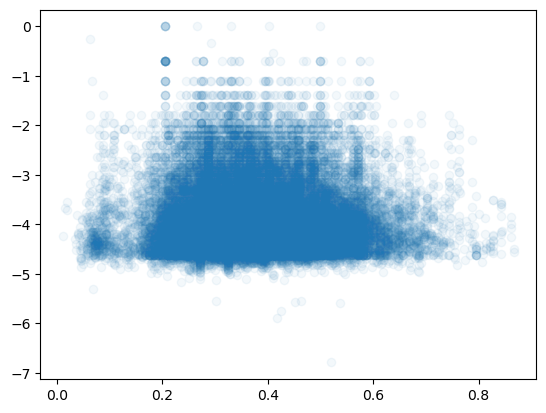

In [107]:
from asodesigner.features.tai import calc_tAI, tai_weights

sc_weights = tai_weights('sc')

all_data_human_gene_premrna_no_nan.loc[:, 'aso_tai_sc'] = [calc_tAI(aso.replace('U','T'), sc_weights) for aso in all_data_human_gene_premrna_no_nan[SEQUENCE]]

print_correlations(all_data_human_gene_premrna_no_nan, 'aso_tai_sc', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'aso_tai_sc', 'log_inhibition')


plt.scatter(all_data_human_gene_premrna_no_nan['aso_tai_sc'], all_data_human_gene_premrna_no_nan['log_inhibition'], alpha=0.05)
plt.show()

Feature: aso_repeats                        , Pearson: -0.04, p-value: 1.5e-12    Target: Inhibition(%)                      
Feature: aso_repeats                        , Spearman: -0.04, p-value: 3.9e-12    Target: Inhibition(%)                      
Feature: aso_repeats                        , Pearson: -0.04, p-value: 4.3e-10    Target: log_inhibition                     
Feature: aso_repeats                        , Spearman: -0.04, p-value: 3.9e-12    Target: log_inhibition                     


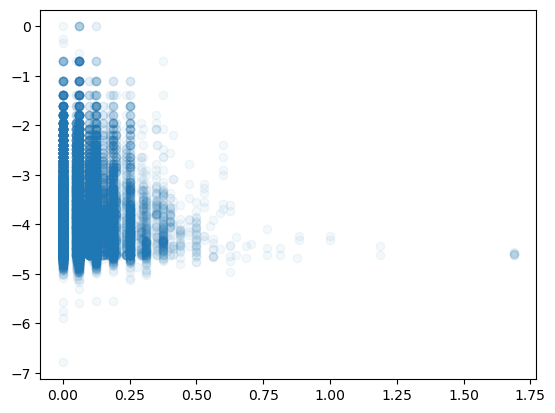

In [119]:
# from asodesigner.features.seq_features import tandem_repeats_score

all_data_human_gene_premrna_no_nan.loc[:, 'aso_repeats'] = [tandem_repeats_score(aso) for aso in all_data_human_gene_premrna_no_nan[SEQUENCE]]

print_correlations(all_data_human_gene_premrna_no_nan, 'aso_repeats', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'aso_repeats', 'log_inhibition')


plt.scatter(all_data_human_gene_premrna_no_nan['aso_repeats'], all_data_human_gene_premrna_no_nan['log_inhibition'], alpha=0.05)
plt.show()

Feature: aso_flexible_fraction              , Pearson: 0.01 , p-value: 0.13       Target: Inhibition(%)                      
Feature: aso_flexible_fraction              , Spearman: 0.01 , p-value: 0.041      Target: Inhibition(%)                      
Feature: aso_flexible_fraction              , Pearson: 0.00 , p-value: 0.52       Target: log_inhibition                     
Feature: aso_flexible_fraction              , Spearman: 0.01 , p-value: 0.041      Target: log_inhibition                     


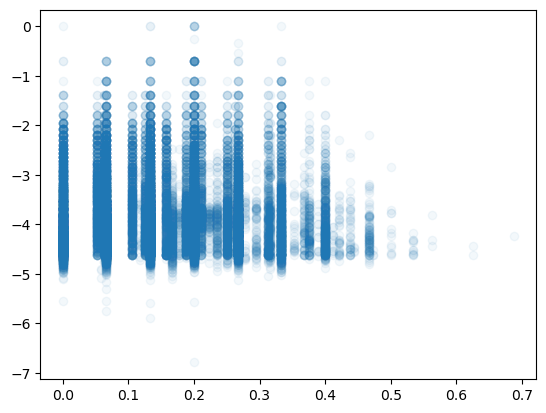

In [133]:
# from asodesigner.features.seq_features import flexible_dinucleotide_fraction

all_data_human_gene_premrna_no_nan.loc[:, 'aso_flexible_fraction'] = [flexible_dinucleotide_fraction(aso) for aso in all_data_human_gene_premrna_no_nan[SEQUENCE]]

print_correlations(all_data_human_gene_premrna_no_nan, 'aso_flexible_fraction', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'aso_flexible_fraction', 'log_inhibition')


plt.scatter(all_data_human_gene_premrna_no_nan['aso_flexible_fraction'], all_data_human_gene_premrna_no_nan['log_inhibition'], alpha=0.05)
plt.show()

Feature: aso_nucleotide_diversity           , Pearson: 0.09 , p-value: 1.3e-52    Target: Inhibition(%)                      
Feature: aso_nucleotide_diversity           , Spearman: 0.08 , p-value: 7.9e-46    Target: Inhibition(%)                      
Feature: aso_nucleotide_diversity           , Pearson: 0.08 , p-value: 6.7e-45    Target: log_inhibition                     
Feature: aso_nucleotide_diversity           , Spearman: 0.08 , p-value: 7.9e-46    Target: log_inhibition                     


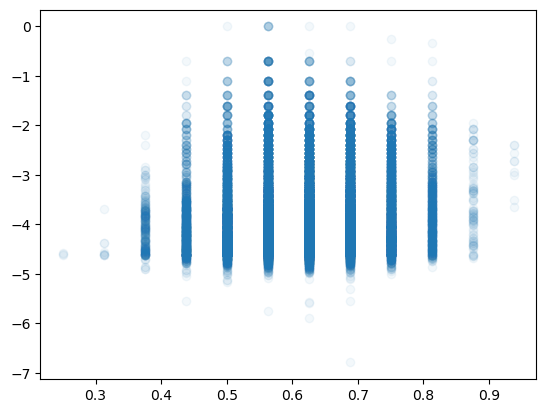

In [134]:
# from asodesigner.features.seq_features import nucleotide_diversity

all_data_human_gene_premrna_no_nan.loc[:, 'aso_nucleotide_diversity'] = [nucleotide_diversity(aso) for aso in all_data_human_gene_premrna_no_nan[SEQUENCE]]

print_correlations(all_data_human_gene_premrna_no_nan, 'aso_nucleotide_diversity', INHIBITION)
print_correlations(all_data_human_gene_premrna_no_nan, 'aso_nucleotide_diversity', 'log_inhibition')


plt.scatter(all_data_human_gene_premrna_no_nan['aso_nucleotide_diversity'], all_data_human_gene_premrna_no_nan['log_inhibition'], alpha=0.05)
plt.show()

In [135]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection  import train_test_split, cross_val_score
from sklearn.metrics import make_scorer
import pandas as pd

filtered = all_data_human_gene_premrna_no_nan.copy()
filtered = filtered[filtered['Cell line organism'] == 'human']
print(len(filtered))


filtered = filtered.dropna(subset=[INHIBITION]).copy()
filtered = filtered.dropna(subset=[DENSITY]).copy()


filtered['log_volume'] = np.log(filtered[VOLUME])
filtered.loc[:, 'log_inhibition'] = -np.log(-filtered[INHIBITION] + 101)
filtered.loc[:, 'log_density'] = np.log(filtered[DENSITY])
filtered.loc[:, SENSE_LENGTH] = [len(sequence) for sequence in filtered[SEQUENCE]]
filtered.loc[:, SENSE_LENGTH] = filtered.loc[:, SENSE_LENGTH].astype(float)
filtered['gc_deviation'] = np.abs(0.5 - filtered['gc_content'])
filtered['self_energy_log_squared'] = filtered['self_energy_log'] ** 2
# filtered['self_energy_squared'] = filtered['self_energy'] ** 2

ONE_HOT_FEATURE_NAMES = [CELL_LINE, DENSITY, TRANSFECTION, 'first_nucleotide', 'second_nucleotide', MODIFICATION, SENSE_TYPE]
for feature in ONE_HOT_FEATURE_NAMES:
    filtered = pd.get_dummies(filtered, columns=[feature]).copy()

# features_base = ['log_volume', TREATMENT_PERIOD, VOLUME]
features_base = ['aso_nucleotide_diversity', 'aso_flexible_fraction', 'aso_repeats', 'aso_tai_sc', 'aso_palindromic_fraction', 'aso_entropy', 'aso_enc', 'gc_content', 'gc_deviation', SENSE_LENGTH, 'normalized_start', SENSE_START, 'self_energy_log', 'self_energy_log_squared', 'internal_fold', 'energy_and_fold', 'gc_content_3_prime_5', 'gc_content_5_prime_5']
experiment_features = [VOLUME, 'log_volume', TREATMENT_PERIOD, 'log_density']

one_hot_encoded_features = []
for one_hot_feature in ONE_HOT_FEATURE_NAMES:
    one_hot_encoded_features.append([feature for feature in filtered.columns if one_hot_feature in feature and one_hot_feature != feature])
# Flatten the list of list to a single big list
flat_one_hot_encoded_features = [feature for sublist in one_hot_encoded_features for feature in sublist]

features = features_base + experiment_features + on_target_energy_features + fold_features + flat_one_hot_encoded_features

print("Used features: ", features)

# filtered = all_data_human_gene_premrna_no_nan
common_chemical_pattern = 'CCCddddddddddCCC'

# filtered = filtered[filtered['Chemical_Pattern'] == common_chemical_pattern]
filtered = filtered[filtered[CANONICAL_GENE] == 'IRF5']
# filtered = filtered[filtered[INHIBITION] > 0]
# filtered = filtered[filtered[VOLUME] == 4000]
# filtered = filtered[filtered[INHIBITION] > 70]

# train, test = train_test_split(filtered, test_size=0.2, random_state=0, stratify=filtered[CANONICAL_GENE])
train, test = train_test_split(filtered, test_size=0.2)

print("Test: ", len(test))
print("Train: ", len(train))
X = train[features]
y = train['log_inhibition']
# x_tag = X
# y_tag = y

weight = VOLUME


# Multiply the values via numpy without changing the column names
multiplier = np.sqrt(X[weight]).values.reshape(-1, 1)
X_tag = pd.DataFrame(
    X[features].values * multiplier,
    index=X.index,
    columns=X[features].columns)


y_tag  = y * np.sqrt(X[weight])

# model = LinearRegression()
# model.fit(X_tag, y_tag)
model = RandomForestRegressor(n_jobs=-1)

# model = RandomForestRegressor(random_state=42, n_jobs=-1)

# model.fit(X,y)
model.fit(train[features], train['log_inhibition'])


baseline_score = cross_val_score(model, X, y, cv=5).mean()
print("Baseline score: ", baseline_score)

def spearman_score(y_true, y_pred):
    return stats.spearmanr(y_true, y_pred).correlation ** 2

spearman_scorer = make_scorer(spearman_score, greater_is_better=True)
spearman_score = cross_val_score(model, X, y, cv=5, scoring=spearman_scorer, n_jobs=-1).mean()
print("Spearman score: ", spearman_score)



29987
Used features:  ['aso_nucleotide_diversity', 'aso_flexible_fraction', 'aso_repeats', 'aso_tai_sc', 'aso_palindromic_fraction', 'aso_entropy', 'aso_enc', 'gc_content', 'gc_deviation', 'sense_length', 'normalized_start', 'sense_start', 'self_energy_log', 'self_energy_log_squared', 'internal_fold', 'energy_and_fold', 'gc_content_3_prime_5', 'gc_content_5_prime_5', 'ASO_volume(nM)', 'log_volume', 'Treatment_Period(hours)', 'log_density', 'on_target_energy_fits800', 'on_target_energy_sum800', 'on_target_energy_max800', 'on_target_energy_fits_normalized800', 'on_target_energy_sum_normalized800', 'on_target_energy_max_normalized800', 'on_target_fold_openness40_15', 'on_target_fold_openness_normalized40_15', 'Cell_line_A-431', 'Cell_line_A431', 'Cell_line_H929', 'Cell_line_HepG2', 'Cell_line_HepaRG', 'Cell_line_Human IPS', 'Cell_line_KARPAS-229', 'Cell_line_KMS11', 'Cell_line_MM.1R', 'Cell_line_NCI-H460', 'Cell_line_SH-SY5Y', 'Cell_line_SK-MEL-28', 'Cell_line_SNU-449', 'Cell_line_U251', 

Pearson Corr:  0.8227877158336288  p_value:  2.0991813129734308e-55
Spearman Corr:  0.7935243298261936  p_value:  6.4017872468514256e-49


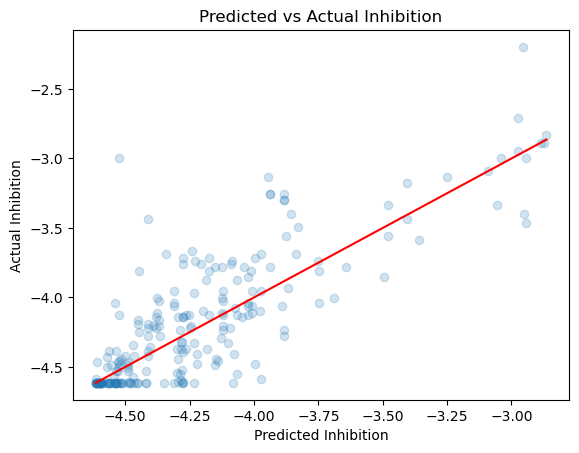

In [136]:
test_filtered = test.copy()
# test_filtered = test_filtered[test_filtered[CANONICAL_GENE] == 'MAPT']
# test_filtered = test_filtered[test_filtered['Chemical_Pattern'] == 'CCCddddddddddCCC']
# test_filtered = test_filtered[test_filtered[INHIBITION] > 90]

test_features = test_filtered[features]
#
# multiplier = np.sqrt(test[weight]).values.reshape(-1, 1)
# test_features = pd.DataFrame(
#     test[features].values * multiplier,
#     index=test.index,
#     columns=test[features].columns)
predicted = model.predict(test_filtered[features])


# test_features = test_filtered[features]
# predicted = model.predict(test_features)
# y_test = test_filtered['log_inhibition'] / np.sqrt(test_filtered[weight])
y_test = test_filtered['log_inhibition']


corr, p_value = pearsonr(y_test, predicted)
print("Pearson Corr: ", corr, " p_value: ", p_value)
corr, p_value = spearmanr(y_test, predicted)
print("Spearman Corr: ", corr, " p_value: ", p_value)
plt.scatter(predicted, y_test, alpha=0.2)
# plt.scatter(y_test, test['gc_content'])
x = np.linspace(np.min(predicted), np.max(predicted), 100)
plt.plot(x, x, color='red')

plt.xlabel('Predicted Inhibition')
plt.ylabel('Actual Inhibition')
plt.title('Predicted vs Actual Inhibition')
plt.show()

In [36]:
from sklearn.model_selection import permutation_test_score

score, permutation_scores, pvalue = permutation_test_score(model, X, y, cv=5, n_permutations=100, n_jobs=-1, scoring='r2')
print(score, permutation_scores, pvalue)

Process LokyProcess-11:
Process LokyProcess-10:
Traceback (most recent call last):
  File "/home/michael/anaconda3/envs/aso_design/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py", line 463, in _process_worker
    r = call_item()
        ^^^^^^^^^^^
  File "/home/michael/anaconda3/envs/aso_design/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py", line 291, in __call__
    return self.fn(*self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michael/anaconda3/envs/aso_design/lib/python3.11/site-packages/joblib/parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/michael/anaconda3/envs/aso_design/lib/python3.11/site-packages/joblib/parallel.py", line 598, in <listcomp>
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "/home/michael/anaconda3/envs/aso_design/lib/python3.11/site-packages/sklearn/utils/parallel.py", line 139,

In [ ]:
plt.scatter(filtered['self_energy_log_squared'], filtered['log_inhibition'], alpha=0.1)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import rankdata

def partial_corr(x, y, z):
    # Regress x on z
    X = sm.add_constant(z)
    model_x = sm.OLS(x, X).fit()
    res_x = model_x.resid

    # Regress y on z
    model_y = sm.OLS(y, X).fit()
    res_y = model_y.resid

    # Compute correlation between the residuals
    return np.corrcoef(res_x, res_y)[0, 1]

def partial_spearman_corr(x, y, z):
    # Convert variables to ranks
    rx = rankdata(x)
    ry = rankdata(y)
    rz = rankdata(z)

    # Regress rx on rz
    X = sm.add_constant(rz)
    model_x = sm.OLS(rx, X).fit()
    res_x = model_x.resid

    # Regress ry on rz
    model_y = sm.OLS(ry, X).fit()
    res_y = model_y.resid

    # Compute the Pearson correlation between the residuals
    return np.corrcoef(res_x, res_y)[0, 1]


for gene in genes_u:
    t = filtered[filtered[CANONICAL_GENE] == gene]
    print("Gene:", gene)
    try:
        pcorr = partial_spearman_corr(t['self_energy'], t['log_inhibition'], t['gc_content'])
        print(pcorr)
    except:
        pass

In [137]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf.fit(filtered[features], filtered['log_inhibition'])

# Get the feature importances
importances = rf.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)



In [138]:
for index, row in importance_df.iterrows():
    print(f"{row['Feature']:<40} {row['Importance']:.3}")


Treatment_Period(hours)                  0.314
ASO_volume(nM)                           0.13
log_volume                               0.123
on_target_energy_sum800                  0.119
on_target_energy_max800                  0.0646
aso_tai_sc                               0.0323
normalized_start                         0.0244
aso_entropy                              0.0228
sense_start                              0.019
aso_enc                                  0.0189
Cell_line_KARPAS-229                     0.0119
Cell_line_A-431                          0.0116
Modification_cEt/5-methylcytosines/deoxy 0.00907
self_energy_log_squared                  0.00816
self_energy_log                          0.0076
Modification_MOE/cEt/5-methylcytosines/deoxy 0.00754
aso_flexible_fraction                    0.00747
aso_palindromic_fraction                 0.0064
gc_content_5_prime_5                     0.00546
internal_fold                            0.00538
aso_nucleotide_diversity            

In [139]:
print("The baseline is: ", baseline_score)
print("The spearman baseline is: ", spearman_score)
cv = 5
scorer = spearman_scorer
jobs = -1
feature_importances = []

# for feature in features_base + on_target_energy_features + fold_features:
for feature in features_base:
    score_without_feature = cross_val_score(model, X.drop(columns=[feature]), y, cv=cv, scoring=scorer, n_jobs=jobs).mean()
    # print(f"Dropping {feature}: performance drop = {baseline_score - score_without_feature}")
    feature_importances.append((feature, float(baseline_score - score_without_feature)))

print("Done base features")

for i in range(len(one_hot_encoded_features)):
    feature_name = ONE_HOT_FEATURE_NAMES[i]
    feature = one_hot_encoded_features[i]

    score_without_feature = cross_val_score(model, X.drop(columns=feature), y, cv=cv, scoring=scorer, n_jobs=jobs).mean()
    performance_diff = baseline_score - score_without_feature
    feature_importances.append((feature_name, float(performance_diff)))


score_without_on_target_energy = cross_val_score(model, X.drop(columns=on_target_energy_features), y, cv=cv, scoring=scorer, n_jobs=jobs).mean()
performance_drop_all_on_target_energy = baseline_score - score_without_on_target_energy
feature_importances.append(("All on target energy", float(performance_drop_all_on_target_energy)))

score_without_fold_features = cross_val_score(model, X.drop(columns=fold_features), y, cv=cv, scoring=scorer, n_jobs=jobs).mean()
performance_drop_fold_features = baseline_score - score_without_fold_features
feature_importances.append(("Fold features", float(performance_drop_fold_features)))


sorted_data = sorted(feature_importances, key=lambda x: x[1], reverse=True)
for datum in sorted_data:
    print(datum)


The baseline is:  0.7504080397040033
The spearman baseline is:  0.6382409637936877
Done base features
('aso_enc', 0.11724938426073239)
('aso_nucleotide_diversity', 0.11557855333019418)
('sense_type', 0.11550350495323025)
('energy_and_fold', 0.11536436872536782)
('sense_length', 0.11520772936390844)
('normalized_start', 0.11509932920885213)
('aso_flexible_fraction', 0.11477758231089186)
('Cell_line', 0.11421329607910835)
('self_energy_log_squared', 0.1138616130910971)
('Fold features', 0.11379302440240213)
('internal_fold', 0.11292253845809508)
('aso_repeats', 0.11185789133766322)
('All on target energy', 0.11184276140306892)
('second_nucleotide', 0.11180321907313429)
('first_nucleotide', 0.11153476333568957)
('aso_entropy', 0.11111949197950455)
('sense_start', 0.11111789505835701)
('gc_deviation', 0.11110124953236211)
('gc_content', 0.11106838575570543)
('gc_content_5_prime_5', 0.11079811991111532)
('self_energy_log', 0.1106741504147769)
('aso_tai_sc', 0.10992837946600686)
('Density(ce

In [ ]:
print(filtered.columns)


for gene in genes_u:
    print("Gene:", gene)

    try:
        predicted_gene = model.predict(filtered[filtered[CANONICAL_GENE] == gene][features])
        y_gene = filtered[filtered[CANONICAL_GENE] == gene]['log_inhibition']
        corr, p_value = pearsonr(y_gene, predicted_gene)
        print("Pearson Corr: ", corr, " p_value: ", p_value)
        corr, p_value = spearmanr(y_gene, predicted_gene)
        print("Spearman Corr: ", corr, " p_value: ", p_value)
    except:
        pass
# plt.scatter(predicted, y)
# plt.show()

In [ ]:
for gene in genes_u:
    print("Gene: ", gene)
    print(len(set(list(all_data_human_gene_premrna_no_nan[all_data_human_gene_premrna_no_nan[CANONICAL_GENE] == gene][SEQUENCE]))))

In [ ]:
subset = ['Sequence', 'Chemical_Pattern', 'Smiles', 'Linkage', 'Location', 'Modification', 'Primer_probe_set', 'ISIS', 'Cell_line', VOLUME, DENSITY]
result = all_data_human_gene_premrna_no_nan.groupby(subset).filter(lambda x: len(x) > 20)
# result = all_data_human_gene_premrna_no_nan
result = result.sort_values(by=['Sequence'])
result